"""  #    
Bloque de introducción

"""  #

# Datasets
## Preparación
### Librerías

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans

"""  #    
### Descarga
Preparamos una función genérica de descarga de los datasets y de su preparación.     
Esta nos permite escoger los atributos que usaremos asi como extraer a un variable aparte las clases en caso de estar disponibles.

"""  #

In [75]:
def load_dataset(dataset_url: str, separator: str = '\s+', class_position: int = None, remove: list = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from archive.ics.uci.edu
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
       if left empty (None), no prediction class will be used (intrinsic case).
    :param list remove: attributes indexes to remove.
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset.iloc[:, class_position]
        # Add class index to the indexes to remove.
        remove = [class_position] if remove is None else remove + [class_position]

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    # Remove noise attributes.
    if remove is not None:
        dataset.drop(remove, axis=1, inplace=True)

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    # TODO: this might result in different classes vs attribute sizes. To be reviewed.
    dataset.dropna(inplace=True)

    return classes, dataset


"""  #    
### Visualización
Usaremos una función común para presentar los datos, tanto como si están clasificados o no.    
También, en caso de usar más de dos atributos del dataset, usaremos el *pairplot* de seaborn para presentar los atributos de dos en dos.

"""  #


In [55]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    # For bidimentionnal datasets, use a simple plot.
    if len(dataset) == 2:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=classes)
        
    # For extra-dimentionnal datasets, compare attribrutes.
    else:
        if classes is not None:
            # Clone dataset to avoid modifying the original one.
            dataset = dataset.copy()
            dataset['classes'] = classes.astype(str)
            sns.pairplot(dataset, hue='classes')
        else:
            sns.pairplot(dataset)
            

## Métricas
### Métricas extrínsecas

In [46]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

In [47]:
def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k] / sum(mat[:,k])

def medida_recall(mat, l, k):
    return mat[l,k] / sum(mat[l,:])

def medida_pureza(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    return np.sum([
        totales[k] * np.max(mat[:,k] / float(np.sum(mat[:,k])))
        for k in np.arange(mat.shape[1])
    ])

In [48]:
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)

def medida_f1(mat):
    totales = np.sum(mat, axis=1) / float(np.sum(mat))
    assign = np.sum([
        totales[l] * np.max([
            medida_f1_especifica(mat, l, k)
            for k in np.arange(mat.shape[1])
        ]) 
        for l in np.arange(mat.shape[0])
    ])
    return assign

In [49]:
def medida_entropia(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    relMat = mat / np.sum(mat, axis=0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat==0]=0.0001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([
        totales[k] * np.sum([
            relMat[l,k]*logRelMat[l,k] 
            for l in np.arange(mat.shape[0])
        ])
        for k in np.arange(mat.shape[1])
    ])

In [50]:
def medida_informacion_mutua(mat):
    relMat = mat/float(np.sum(mat))
    logRelMat = mat.copy()
    logRelMat = logRelMat/np.sum(mat,0,keepdims=True)
    logRelMat = logRelMat/np.sum(mat,1,keepdims=True)
    logRelMat[logRelMat==0]=0.000001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(np.sum(mat) * logRelMat)
    return np.sum([
        np.sum([
            relMat[l,k]*logRelMat[l,k]
            for l in np.arange(mat.shape[0])
        ])
        for k in np.arange(mat.shape[1])
    ])

####  Agrupación métricas extrínsecas

In [60]:
def extrinsic_metrics(real_classes, predicted_classes):
    confusion_matrix = matriz_confusion(real_classes, predicted_classes)
    
    return {
        'error': medida_error(confusion_matrix),
        'purity': medida_pureza(confusion_matrix),
        'f1': medida_f1(confusion_matrix),
        'entroy': medida_entropia(confusion_matrix),
        'mutual_information': medida_informacion_mutua(confusion_matrix)
    }

### Métricas intrínsecas

In [40]:
def medida_RMSSTD(X, Xyp, cXs):
    labels = np.unique(Xyp)
    num = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    den = X.shape[1] * np.sum([np.sum(Xyp==labels[k])-1 for k in np.arange(labels.size)])

    return np.sqrt(num / den)


In [41]:
def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    
    return 1 - interior / sumTotal

In [42]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def calcular_matriz_a(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/(np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])-1)
    aX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        aX[i] = factores[k] * np.sum([mD[i,ip] 
                                      for ip in np.arange(X.shape[0])[Xyp==labels[k]]])
    return(aX)

def calcular_matriz_b(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])
    bX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        ran = np.arange(labels.size)
        ran = ran[np.arange(labels.size)!=k]
        res = np.array([factores[h] * np.sum([mD[i,ip]
                                              for ip in np.arange(X.shape[0])[Xyp==labels[h]]])
                        for h in ran])
        bX[i] = np.min(res)
    return(bX)

def medida_silueta(X, Xyp, distancia):
    mD = matriz_distancias(X, distancia)

    A = calcular_matriz_a(X, Xyp, mD)
    B = calcular_matriz_b(X, Xyp, mD)
    impl = np.subtract(B, A) / np.maximum(A, B)
    
    return np.mean(impl)


In [43]:
def medida_calinski_harabasz(X, Xyp, cXs, distancia):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    factores = np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])

    num = (X.shape[0]-labels.size)*np.sum([factores[k]*distancia(cXs[k,:],cXglob)**2 
                                           for k in np.arange(cXs.shape[0])])
    den = (labels.size-1)*np.sum([np.sum([distancia(X[i,:],cXs[k,:])**2 
                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                                           for k in np.arange(cXs.shape[0])])
    return num/den

In [44]:
def medida_I(X, Xyp, cXs, distancia, p=1):
    cXglob = np.mean(X, axis = 0) 
    labels = np.sort(np.unique(Xyp))
    maxDcs = np.max(matriz_distancias(cXs, distancia))

    num = np.sum([distancia(X[i,:], cXglob) for i in np.arange(X.shape[0])])

    den = labels.size * np.sum([
        np.sum([
            distancia(X[i,:], cXs[k,:])
            for i in np.arange(X.shape[0])[Xyp==labels[k]]
        ])
        for k in np.arange(cXs.shape[0])
    ])
    
    return (num / den * maxDcs) ** p

In [45]:
def medida_davies_bouldin(X, Xyp, cXs, distancia):
    labels = np.sort(np.unique(Xyp))
    mDcs = matriz_distancias(cXs, distancia)
    np.fill_diagonal(mDcs, np.Infinity)

    vals = np.array([1.0 / np.sum(Xyp==labels[k]) * np.sum([distancia(X[i,:], cXs[k,:])
                                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                     for k in np.arange(cXs.shape[0])])
    res = 1.0/labels.size*np.sum([np.max([(vals[k]+vals[kp])/mDcs[k,kp] 
                                          for kp in np.arange(labels.size)])
                                  for k in np.arange(labels.size)])
    return res

####  Agrupación métricas intrínsecas

## Selección

"""  #    
### Dataset extrínseca
los cilindros están en posición 1 (partiendo de 0)
no los he eliminado para que veamos el hue

"""  #

In [53]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, class_position=1, remove=[7, 8])

/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


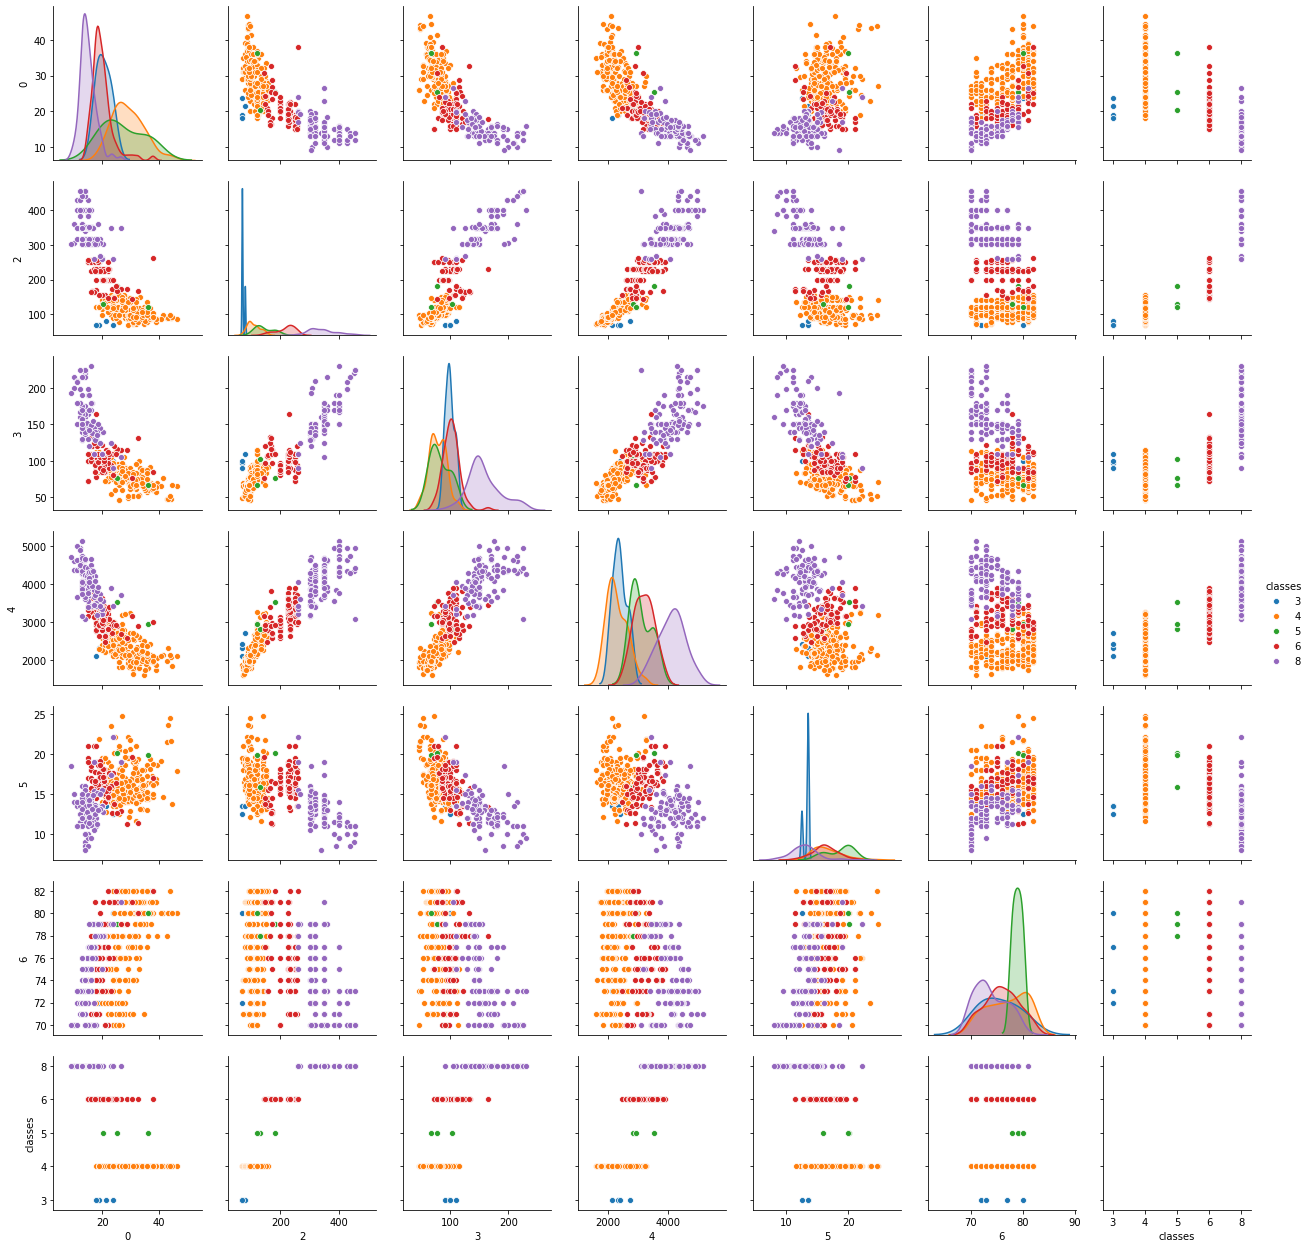

In [56]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

"""  #    
blablabla

"""  #

"""  #    
## Dataset intrínseca
El dataset intrínseca **Aggregations** está generado de manera artificial por: *A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007*


Este dataset está compuesto por 788 observaciones de 2 variables que abarcan un amplio rango numérico. En el conjunto de datos existen entre 5 a 7 grupos que se distribuyen en zonas particulares del rango de valores de las variables.


Cargamos nuestro dataset (*intrinsic_dataset*):

"""  #

In [23]:
dataset_url = 'http://cs.joensuu.fi/sipu/datasets/Aggregation.txt'
_, intrinsic_dataset = load_dataset(dataset_url, remove=[2])

"""  #    
Visualizamos el dataset en 2-D.

"""  #

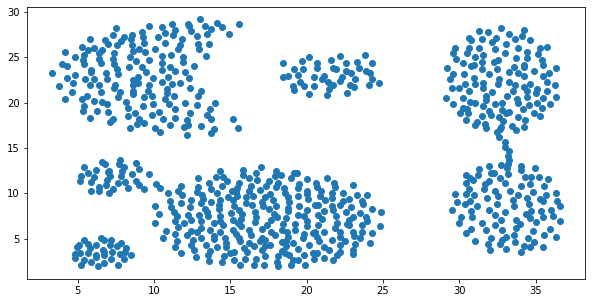

In [35]:
plot_dataset(intrinsic_dataset)

"""  #    
Destacamos que se podría clasificar con 4, 5 o con 7 clusters.

"""  #

"""  #    
# Algoritmos
Preparamos funciones 'herramienta' para cada algoritmo de forma a poder analizarlos.

"""  #

## K-Means

"""  #    
Métrica R cadrado. No usamos directamente la de sklean al esta necesitar la clases reales.
Nos permite valorar el ratio de distancia intraclúster con respecto a la distancia interclúster.

"""  #


In [81]:
def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R² score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator


"""  #    
Función para generar gráficamente la evolución de las métricas R² y Silueta según el número de cluters, de forma a escoger el número de clusters óptimo, usando la técnica del codo.

"""  #


In [82]:
def kmeans_plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")


# Análisis dataset extrínseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

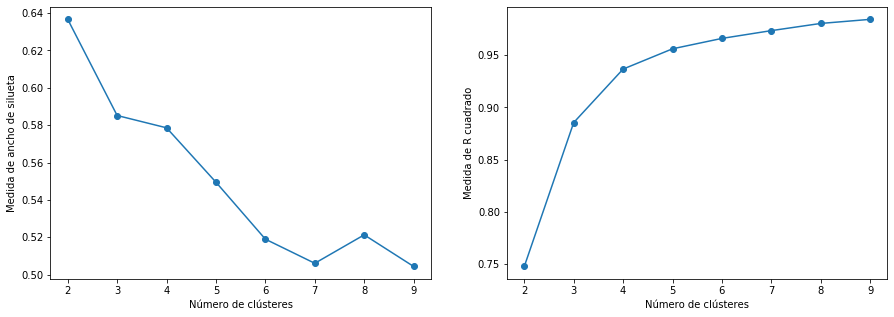

In [83]:
kmeans_plot_clusters_selection(extrinsic_dataset)

"""  #    
Vemos un "codo" pronunciando con 4 clusters, pero el ancho de silueta es "mínimo" a partir de 6 clusters.     
Escogemos 5 clusters como punto intermedio.

"""  #

#### Ejecución del algoritmo

/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


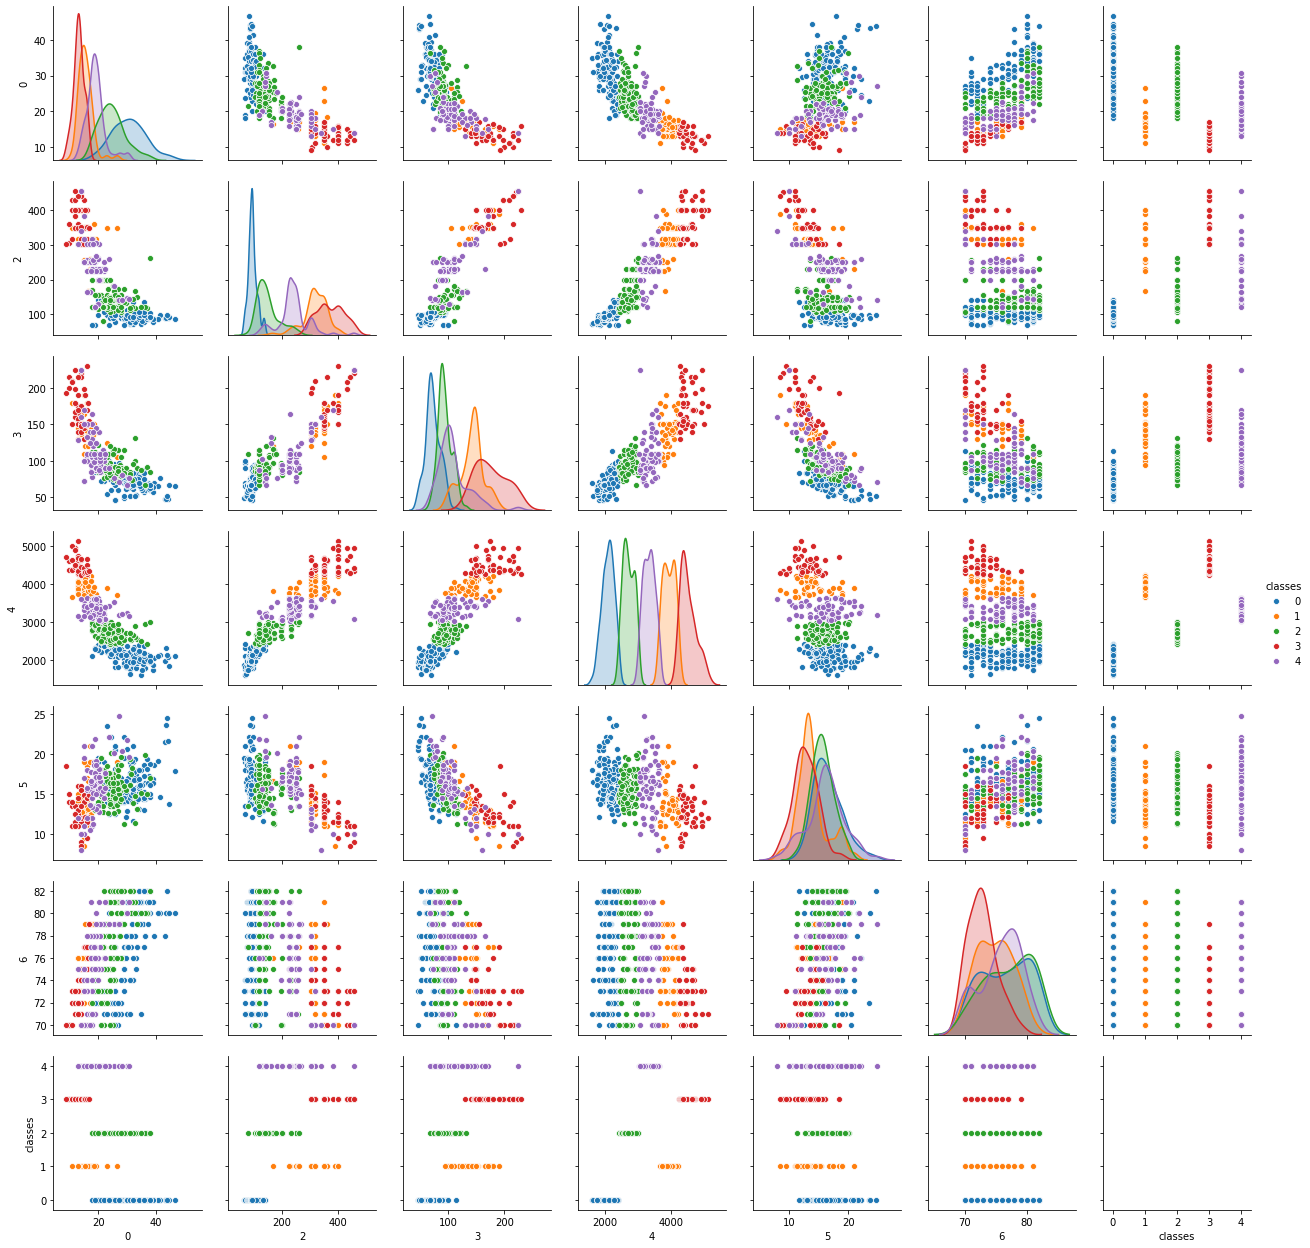

In [61]:
kmeans = KMeans(n_clusters=5).fit(extrinsic_dataset)
extrinsic_kmeans_prediction = kmeans.predict(extrinsic_dataset)

plot_dataset(extrinsic_dataset, extrinsic_kmeans_prediction)

#### Métricas de k-means

In [63]:
#display(extrinsic_metrics(extrinsic_classes, extrinsic_kmeans_prediction))

### Algoritmo 2

### Algoritmo 3

### Algoritmo 4

### Algritmo 5

## Comparación algoritmos

# Análisis dataset intrínseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

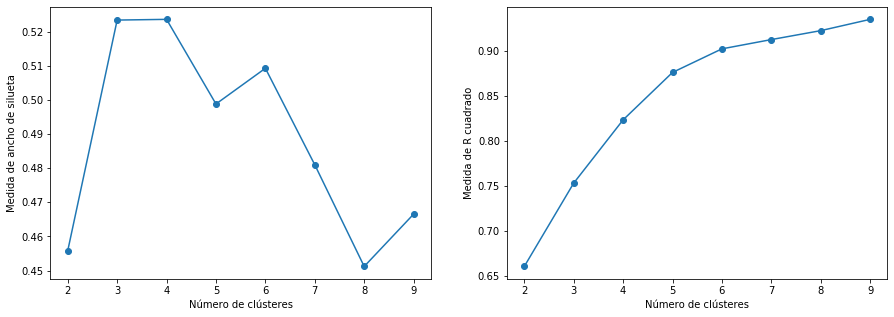

In [89]:
kmeans_plot_clusters_selection(intrinsic_dataset)

"""  #    
Según el procedimiento del codo, escogeríamos entre 5 y 7 clusters

"""  #

"""  #
#### Ejecución del algoritmo
Ejecutamos la predicción de k-means con 5 clusters y visualizamos la agrupación generada.


"""  #

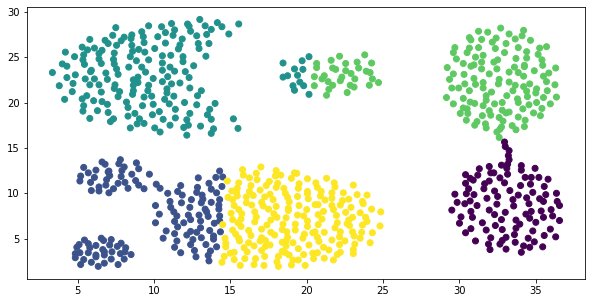

In [39]:
kmeans = KMeans(n_clusters=5).fit(intrinsic_dataset)
prediction = kmeans.predict(intrinsic_dataset)

plot_dataset(intrinsic_dataset, prediction)

"""  #    
Vemos que mientras se han logrado aislar algunos grupos, otros claramente se han quedado a medias.

"""  #

### Algoritmo 2

### Algoritmo 3

### Algoritmo 4

### Algoritmo 5

## Comparación algoritmos

# Conclusión